<a href="https://colab.research.google.com/github/theojolliffe/snoracle/blob/main/Fourier_Transform_Snore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier Transform

In the [previous tutorial](https://colab.research.google.com/github/jinglescode/python-signal-processing/blob/main/tutorials/Signal%20composition%20-%20time%2C%20sampling%20rate%20and%20frequency.ipynb), we learned that combining multiple signals will produce a new signal where all the frequencies are jumbled up. In this tutorial, we will learn about Fourier Transform and how it can take a complex signal and decompose it to the frequencies that made it up.

## Load packages

We will download [splearn](https://github.com/jinglescode/python-signal-processing), a package that consists of datasets, common signal processing functions and machine learning model architectures.

In [1]:
#@title 
!git clone https://github.com/jinglescode/python-signal-processing.git
%cd python-signal-processing
!pip install -r requirements.txt --quiet

Cloning into 'python-signal-processing'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 301 (delta 151), reused 199 (delta 68), pack-reused 0
Receiving objects: 100% (301/301), 22.36 MiB | 23.77 MiB/s, done.
Resolving deltas: 100% (151/151), done.
/content/python-signal-processing


In [ ]:
#@title 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import IPython.display as ipd

from splearn.data.generate import generate_signal # https://github.com/jinglescode/python-signal-processing/blob/main/splearn/data/generate.py
from splearn.fourier import fast_fourier_transform # https://github.com/jinglescode/python-signal-processing/blob/main/splearn/fourier.py

sampling_rate = 8000

## What is Fourier transform?

Fourier transform, this is the definition taken from Wikipedia:

> Fourier transform is a mathematical transform that decomposes a function (often a function of time or a signal) into its constituent frequencies.

What does this mean? 

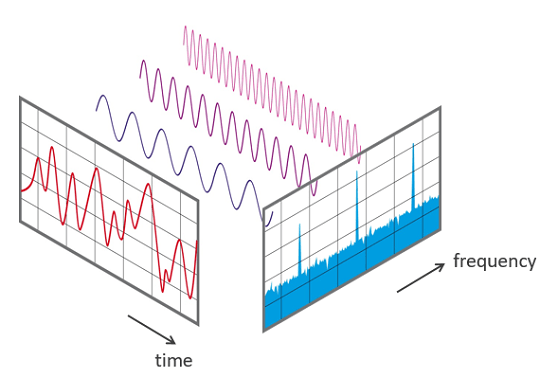

Essentially, Fourier transform converts the domain of time into the domain of frequencies.


To understand this, we can illustrate with a piano. Each key on the piano generates a unique sound wave when the hammer hits the strings based on the strings' thickness and tension. Each key sounds different because each key on the piano has a unique frequency. 

For example, when we play the C-major chord, it is made up of three notes, C, E, and G. If we look up for the [frequencies of these keys](https://en.wikipedia.org/wiki/Piano_key_frequencies), we get 262 Hz (C), 330 Hz (E), and 392 Hz (G). Each key will generate a signal, the frequency represents the pitch, and the amplitude represents the loudness (how hard you hit the keys). 

Illustrate C note:


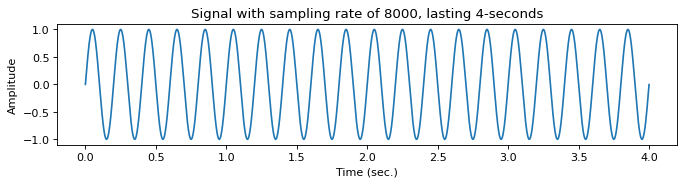

Illustrate E note:


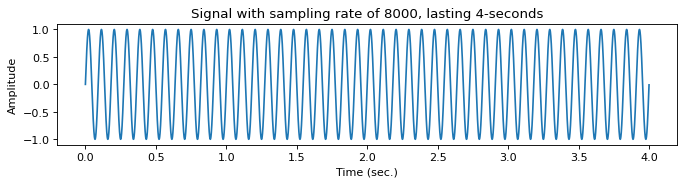

Illustrate G note:


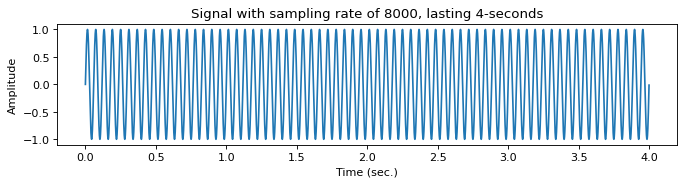

In [ ]:
#@title 

# frequencies are replaced so that we can visualize the differences for illustration

print("Illustrate C note:")
figure(num=None, figsize=(10, 2), dpi=80, facecolor='w', edgecolor='k')
s1 = generate_signal(
    length_seconds=4, 
    sampling_rate=sampling_rate, 
    frequencies=[5],
    plot=True
)

plt.show()

print('Illustrate E note:')
figure(num=None, figsize=(10, 2), dpi=80, facecolor='w', edgecolor='k')
s1 = generate_signal(
    length_seconds=4, 
    sampling_rate=sampling_rate, 
    frequencies=[11],
    plot=True
)
plt.show()

print('Illustrate G note:')
figure(num=None, figsize=(10, 2), dpi=80, facecolor='w', edgecolor='k')
s1 = generate_signal(
    length_seconds=4, 
    sampling_rate=sampling_rate, 
    frequencies=[17],
    plot=True
)
plt.show()

When we combine multiple signals, it is essentially a sum of all the signals (s1 + s2 + s3). So let's go ahead and generate a 4-seconds sound wave containing these frequencies. We will use a sampling rate of 8 kHz; it is the telephone audio sampling rate.

C-major chord, a signal consisting of 262 Hz (C), 330 Hz (E), and 392 Hz (G):


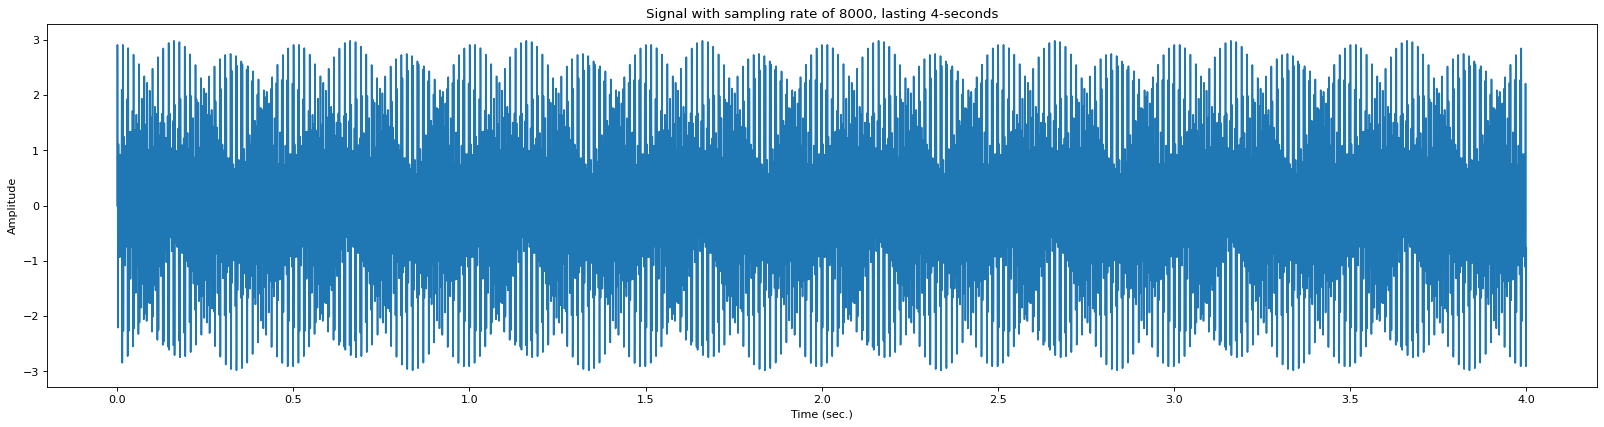

In [ ]:
print('C-major chord, a signal consisting of 262 Hz (C), 330 Hz (E), and 392 Hz (G):')

figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
s1 = generate_signal(
    length_seconds=4, 
    sampling_rate=sampling_rate, 
    frequencies=[262, 330, 392],
    plot=True
)

In [ ]:
!pip install pydub

In [ ]:
import pydub 
import numpy as np

def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")


In [ ]:
!pwd

/content/python-signal-processing


In [ ]:
snore = read('14secsnore.mp3')

As we have expected, we get a signal; it looks kinda pretty because there is no noise and they start at the same time. Let's listen to see how it sounds like.

In [ ]:
ipd.Audio(s1, rate=sampling_rate)

It doesn't sound like the C-major chord, but we can still use this for our learning. Since we are at it, let's include random noise into the signal to mimic that our microphone has picked some background noise.

C-major chord, with static noise


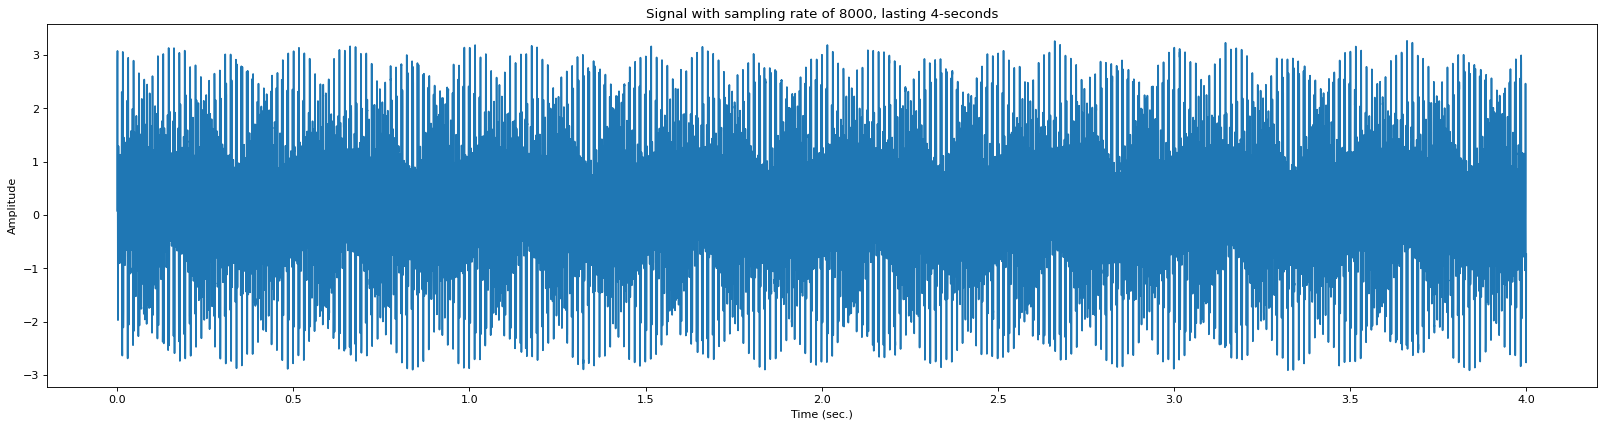

In [ ]:
print('C-major chord, with static noise')

figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
s1 = generate_signal(
    length_seconds=4, 
    sampling_rate=sampling_rate, 
    frequencies=[262, 330, 392],
    add_noise=0.3,
    plot=True
)

ipd.Audio(s1, rate=sampling_rate)

There we go, a sound wave containing our selected frequencies and noisy static sound. We have different frequencies mixed together, it is difficult to identify the frequency components by looking at the signal, can we identify and recover the three frequencies in this signal?

## Decomposes signal into frequencies

We can apply Fourier transform to decompose this signal and identify all the frequencies that are buried in this signal, especially the three frequencies (262 Hz, 330 Hz, and 392 Hz) we have selected to generate this signal.

Signal in frequency domain after performing FFT:


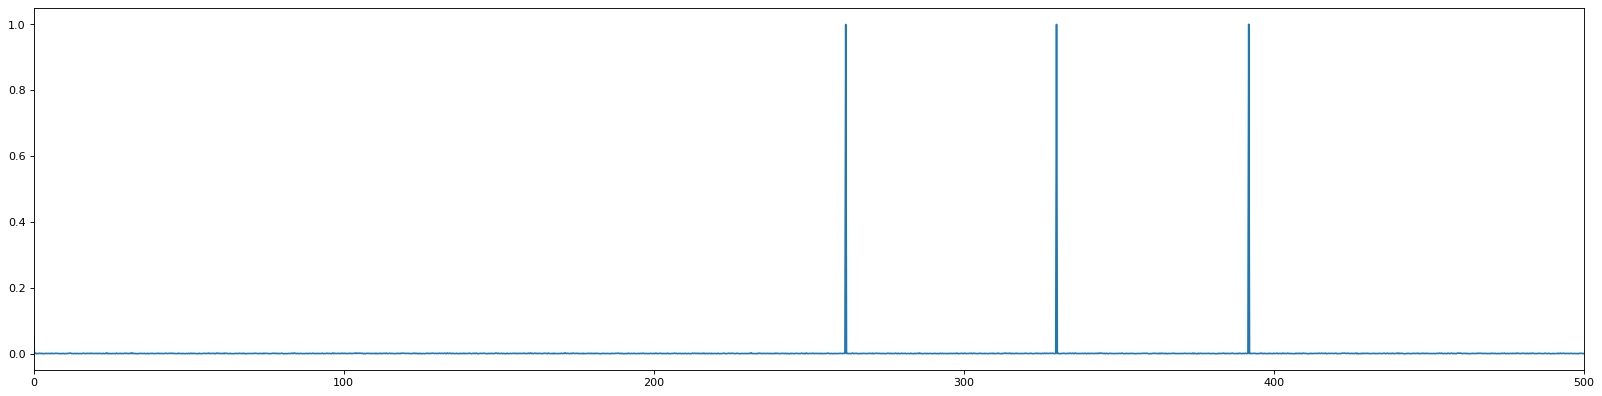

In [ ]:
print('Signal in frequency domain after performing FFT:')

figure(num=None, figsize=(25, 6), dpi=80, facecolor='w', edgecolor='k')
s2 = fast_fourier_transform(
    signal=s1, 
    sampling_rate=sampling_rate, 
    plot=True, 
    plot_xlim=[0, 500], 
)

Here we plot a chart showing each frequency's amplitude in the signal, where the x-axis represents each frequency (showing from 0 Hz to 500 Hz), and the y-axis is the amplitude. You can click on the graph to zoom in.

Despite the noisy background, we can clearly identify that there are three distinct frequencies in this signal. This technique can also work if you record a chord with your phone and upload it; Fourier transform can identify prominent frequencies. 

### Understanding deeper: why Fourier transform works?

3Blue1Brown did a brilliant animation to show how signals can be "unwind" to identify its unlying frequencies—highly recommended to check it out if you are keen to find out more.

Video: [But what is the Fourier Transform? A visual introduction.](https://www.youtube.com/watch?v=spUNpyF58BY&vl=en)

In [ ]:
#@title 
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/spUNpyF58BY" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

In [ ]:
y = np.array([signal[0] for signal in snore[1]])
y

array([ -79, -158, -166, ...,    0,   -1,   -1], dtype=int16)

Check out this [article](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/) that uses `from smoothie to recipe` illustration to explain how Fourier Transform works.

In [ ]:
x = np.linspace(0.0, N*T, N) # x-axis, running number
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) # the signal
y

array([ 0.00000000e+00,  6.77605809e-01,  1.18388467e+00,  1.39967009e+00,
        1.29218938e+00,  9.19997799e-01,  4.07887247e-01, -9.82103194e-02,
       -4.79459667e-01, -6.78188744e-01, -7.06482649e-01, -6.28074866e-01,
       -5.22533667e-01, -4.47207340e-01, -4.12666222e-01, -3.81446536e-01,
       -2.90150572e-01, -8.52515816e-02,  2.42875273e-01,  6.42801578e-01,
        1.01040273e+00,  1.22125465e+00,  1.17580188e+00,  8.40372252e-01,
        2.67883660e-01, -4.10883857e-01, -1.02387034e+00, -1.41022120e+00,
       -1.47061736e+00, -1.19789101e+00, -6.77332143e-01, -5.69409160e-02,
        5.01423072e-01,  8.72476115e-01,  1.00197364e+00,  9.14064066e-01,
        6.90766954e-01,  4.33160666e-01,  2.20279941e-01,  8.18357627e-02,
       -5.24787838e-03, -9.63632600e-02, -2.44434712e-01, -4.66221097e-01,
       -7.24667222e-01, -9.35781896e-01, -9.98525284e-01, -8.36603721e-01,
       -4.35686335e-01,  1.39436967e-01,  7.56113042e-01,  1.25125742e+00,
        1.48266353e+00,  

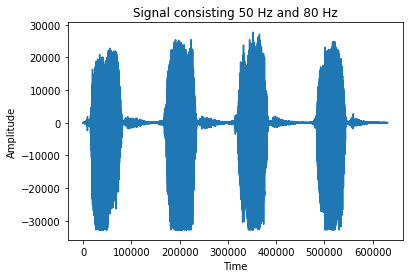

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


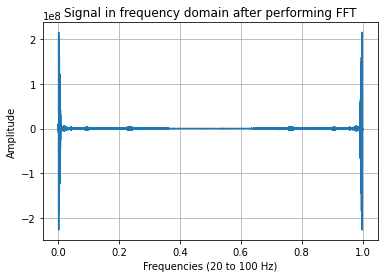

In [ ]:
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

# N = 600 # Number of sample points
# T = 1.0 / 800.0 # time steps
# x = np.linspace(0.0, N*T, N) # x-axis, running number
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x) # the signal
# x = np.linspace(0, 1, len(snore))
# y= snore
# plot the signal
plt.title('Signal consisting 50 Hz and 80 Hz')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(y) 
plt.show()

yf = fft(y) # perform FFT

# plot the graph to show frequency domain
xf = np.linspace(0, 1, len(yf))
# yf = snore
plt.plot(xf, yf)
# plt.xlim(20, 100)
plt.title('Signal in frequency domain after performing FFT')
plt.xlabel('Frequencies (20 to 100 Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

### Understanding deeper: the code

[SciPy](https://www.scipy.org/) has a function [scipy.fft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html), which computes the discrete Fourier Transform with the efficient Fast Fourier Transform (FFT) algorithm. This algorithm is developed by James W. Cooley and John W. Tukey in 1965, in their paper, [An algorithm for the machine calculation of complex Fourier series](https://www.jstor.org/stable/2003354).

In this tutorial, we perform FFT on the signal by using the [fast_fourier_transform](https://github.com/jinglescode/python-signal-processing/blob/main/splearn/fourier.py). Essentially, we are calling the `scipy.fft` function, `y = fft(signal)`. Here is the code for generating the signal with NumPy, performing FFT with SciPy, and plot both graph with Matplotlib.


# Endnotes

Thanks for checking out this tutorial. I hope it has been helpful. If you find any mistakes or have any questions, please do not hesitate to [submit an issue](https://github.com/jinglescode/python-signal-processing/issues). Feel free to connect with me on [GitHub](https://github.com/jinglescode) and [LinkedIn](https://www.linkedin.com/in/jingles).

`fast_fourier_transform` function is used in this repo and it is taken from [splearn.fourier](https://github.com/jinglescode/python-signal-processing/blob/main/splearn/fourier.py).
